## Subsection 1 - Calculating the trajectory and plotting Poincaré map

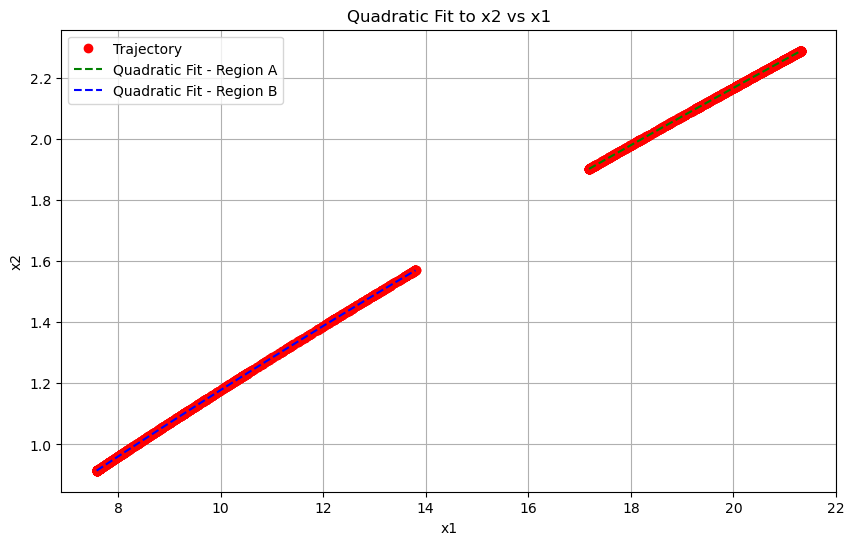

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp  
import matplotlib.pyplot as plt

# Define the system of ODEs
def system(t, x):
    x1, x2, x3 = x
    dx1dt = 4 * x2**2 - 2 * x2 * x3 + 2.1 * x3
    dx2dt = x3 - 2 * x2
    dx3dt = x2 - x1
    return [dx1dt, dx2dt, dx3dt]

# Define the event function: x3 = 0 and x1 > 0
def return_event(t, x):
    return x[2]  # x3 = 0

return_event.terminal = False  # Stop the integration at the event
return_event.direction =-1     # Look for crossings from x3 < 0 to x3 > 0

def integrate_and_find_return(x1_0, x2_0, t_span):
    x0 = [x1_0, x2_0, -0.00001]
    # stop solve_ivp after max_num_events events
    sol = solve_ivp(system, t_span, x0, events=return_event, dense_output=True, max_step=0.01)

    if sol.t_events[0].size == 0:
        raise RuntimeError("No return to x3 = 0 detected in time span.")
    
    t_r = sol.t_events[0] # times when x3 crosses zero
    x_r = sol.sol(t_r) # solution at these times
        
    return x_r[0], x_r[1]

# For writing this function, I was assisted by GitHub Copilot.
def quadratic_fit_function(x_1, x_2):
    coeffs = np.polyfit(x_1, x_2, 2)
    return np.poly1d(coeffs)

# Example usage
x1_0 = 20.
x2_0 = 2.1
x1_tr_original, x2_tr_original = integrate_and_find_return(x1_0, x2_0, t_span=(0, 10000))
points = zip(x1_tr_original, x2_tr_original)
sorted_points = sorted(points, key=lambda p: p[0])
x1_tr, x2_tr = zip(*sorted_points)
# extract x1_tr and x2_tr as numpy arrays
x1_tr = np.array(x1_tr)
x2_tr = np.array(x2_tr)

# Plotting the trajectory and the quadratic fit
plt.figure(figsize=(10, 6))
plt.plot(x1_tr, x2_tr, 'ro', label='Trajectory')

# Calculate the range of the two regions of the trajectory
# create a shifted-left x1_tr array to find the value where the trajectory is separated
separation_index = np.argmax(x1_tr[1:] - x1_tr[:-1])
x_A_l = x1_tr[separation_index]
x_A_r = x1_tr[-1]

x_B_r = x1_tr[separation_index - 1]
x_B_l = x1_tr[0]

# Deviding the trajectory into two regions based on x1
# extract the indexes of the points in each region
# Region A: x_A_l <= x1_tr <= x_A_r
# Region B: x_B_l <= x1_tr <= x_B_r
A_indexes = np.where((x_A_l < x1_tr) & (x1_tr <= x_A_r))
x1_A = x1_tr[A_indexes]
x2_A = x2_tr[A_indexes]

B_indexes = np.where((x_B_l <= x1_tr) & (x1_tr <= x_B_r))
x1_B = x1_tr[B_indexes]
x2_B = x2_tr[B_indexes]

# Fit a quadratic function to the points where x1 > 15
fit_func_A = quadratic_fit_function(x1_A, x2_A)
x1_A_fit = np.linspace(np.min(x1_A), np.max(x1_A), 100)
x2_A_fit = fit_func_A(x1_A_fit)
plt.plot(x1_A_fit, x2_A_fit, 'g--', label='Quadratic Fit - Region A')

fit_func_B = quadratic_fit_function(x1_B, x2_B)
x1_B_fit = np.linspace(np.min(x1_B), np.max(x1_B), 100)
x2_B_fit = fit_func_B(x1_B_fit)
plt.plot(x1_B_fit, x2_B_fit, 'b--', label='Quadratic Fit - Region B')


plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Quadratic Fit to x2 vs x1')
plt.legend()
plt.grid()


## Subsection 2 - Defining 1-DOF reduced Poincaré map

20.499363207246933
8.690736188654677
19.230550580999562
10.536047559357698
21.186093888774888
7.75875505392709
17.5452851059225
13.204224611733187
20.00737625844323
9.388780941461214
20.221346064103397
9.081756158675844
19.81881285451376
9.661297437027056
20.53015265902647
8.647996250982267
19.161494940805728
10.640826431628295
21.228490527253406
7.702812616535663
17.43373114058813
13.387847828786443
19.785761450535308
9.710696434799326
20.581305779516274
8.577068407921168
19.044949326003362
10.818629413801593
21.282347851062205
7.632024112697423
17.291165613716988
13.623470451723367
19.48375873458552
10.156966498823653
20.96730989257772
8.050430498227206
18.109769881648436
12.286712919697274
20.892372797061963
8.151824844441071
18.29889528066227
11.984214521776305
21.08701781274888
7.89045755028322
17.803965064498115
12.781209762764341
20.465407554664964
8.738754560992323
19.307273995861852
10.420139955455227
21.130008798423024
7.833050034593967
17.691860972028532
12.964032208502722
2

C:\Users\TLP-001\AppData\Local\Temp\ipykernel_69844\961331489.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1_values, x2_values, c=color_values, cmap='viridis', label='Poincaré Map Points')


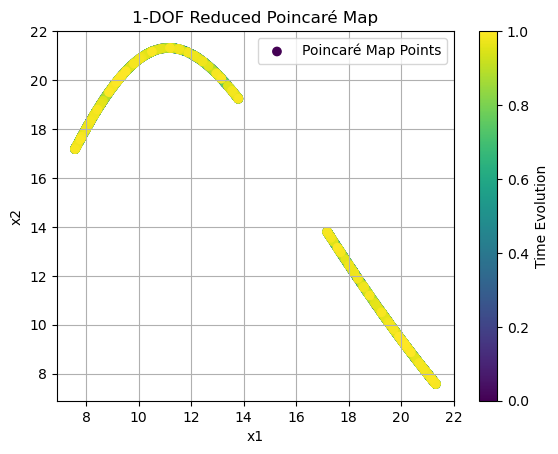

In [ ]:
# used auto-complete of GitHub Copilot to write this function.
def get_x2_fit(x1, tol=1e-2):
    if x_A_l - tol <= x1 <= x_A_r + tol:
        return fit_func_A(x1)
    elif x_B_l - tol <= x1 <= x_B_r + tol:
        return fit_func_B(x1)
    
    # The map action is not defined for x1 outside the regions A and B

def p(x1):
    x2 = get_x2_fit(x1)
    return_event.terminal = True  # Stop the integration at the event (one action)
    # make sure that the inegration is stopped at the first event
    new_x1 = integrate_and_find_return(x1, x2, t_span=(0,1000))[0][0]
    print(new_x1)
    return new_x1


# Plot the 1-DOF reduced Poincaré map
# Use colors to demonstrate the time evolution of the trajectory
# use original points array from the trajectory to assign colors for the points of the trajectory,
# and then plot the points on the Poincaré map with the same colors.

# use poincare_map to get the corresponding x2 values for the Poincaré map
# and plot the points with the same colors
x1_values = x1_tr_original
x2_values = [p(x1) for x1 in x1_values]
colors = plt.cm.viridis(np.linspace(0, 1, len(x1_values)))
color_values = [colors[i] for i in range(len(x1_values))]

# scatter plot of the Poincaré map, where each point is colored according to its time evolution
plt.scatter(x1_values, x2_values, c=color_values, cmap='viridis', label='Poincaré Map Points')
plt.colorbar(label='Time Evolution')
plt.title('1-DOF Reduced Poincaré Map')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.show()



## Subsection 3 - Defining 1-DOF reduced Poincaré map for $P^2$

8.690736188654677
19.230582385080094
10.536047559357698
21.186134751013725
7.75875505392709
17.545398996135958
13.204224611733187
20.007382013243706
9.388780941461214
20.221162569322406
9.081756158675844
19.81884853342861
9.661297437027056
20.530203090963205
8.647996250982267
19.161527203311113
10.640826431628295
21.22852614538245
7.702812616535663
17.43385466944574
13.387847828786443
19.7858064329644
9.710696434799326
20.58114134384081
8.577068407921168
19.044982872836602
10.818629413801593
21.282372754607664
7.632024112697423
17.29129990701944
13.623470451723367
19.48386749063241
10.156966498823653
20.967184585851527
8.050430498227206
18.10983967052896
12.286712919697274
20.892302850207457
8.151824844441071
18.298796071068946
11.984214521776305
21.086956721685098
7.89045755028322
17.80394026485302
12.781209762764341
20.465355585578386
8.738754560992323
19.307092785908274
10.420139955455227
21.130054446745614
7.833050034593967
17.691962229224927
12.964032208502722
20.276987920253653
9

C:\Users\TLP-001\AppData\Local\Temp\ipykernel_69844\1539780156.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x1_values, x2_values, c=color_values, cmap='viridis', label='Poincaré Map Points')


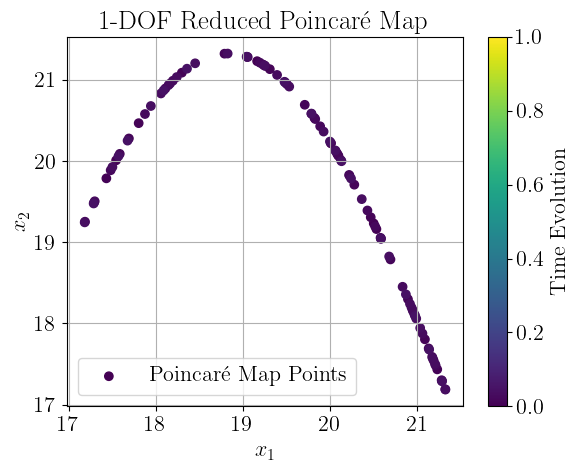

In [ ]:
def p_2(x1):
    return p(p(x1))

x1_values = x1_tr_original[(x_A_l <= x1_tr_original) & (x1_tr_original <= x_A_r)][:100]
x2_values = [p_2(x1) for x1 in x1_values]
color_values = color_values[:100]

# scatter plot of the Poincaré map, where each point is colored according to its time evolution
plt.scatter(x1_values, x2_values, c=color_values, cmap='viridis', label='Poincaré Map Points')
plt.colorbar(label='Time Evolution')
plt.title('1-DOF Reduced Poincaré Map (Region A)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid()
plt.show()


# Applying a quadratic fit to the Poincaré map
p2_quad_fit = quadratic_fit_function(x1_values, x2_values)



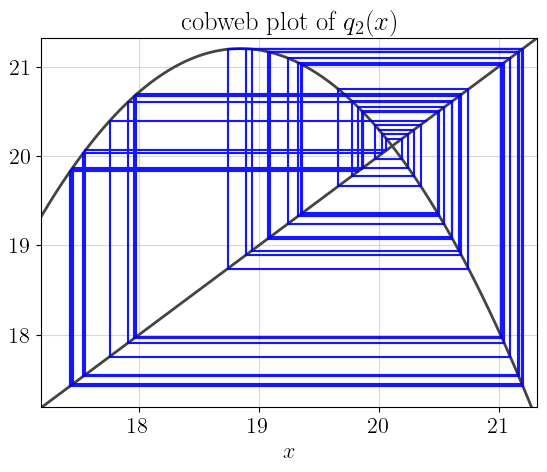

In [44]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt

q2 = p2_quad_fit   

def plot_cobweb(x0, nmax=100):
    """Make a cobweb plot.

    Plot y = f(x; r) and y = x for 0 <= x <= 1, and illustrate the behaviour of
    iterating x = f(x) starting at x = x0. r is a parameter to the function.

    """
    x = np.linspace(np.min(x1_values), np.max(x1_values), 500)
    # Plot y = f(x) and y = x
    plt.plot(x, q2(x), c='#444444', lw=2)
    plt.plot(x, x, c="#444444", lw=2)

    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,nmax+1,2))
    px[0], py[0] = x0, q2(x0)
    for n in range(1, nmax, 2):
        px[n] = px[n-1]
        py[n] = q2(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]

    # Plot the path traced out by the iteration.
    plt.plot(px, py, c='b', alpha=0.7)

    # Annotate and tidy the plot.
    plt.grid(which='minor', alpha=0.5)
    plt.grid(which='major', alpha=0.5)
    plt.xlim(np.min(x1_values), np.max(x1_values))
    plt.ylim(np.min(x2_values), np.max(x2_values))
    plt.xlabel('$x$')
    plt.title('cobweb plot of $q_2(x)$')

x_0 = 20.
plot_cobweb(x_0)


## Subsection 4 - Fixed Point

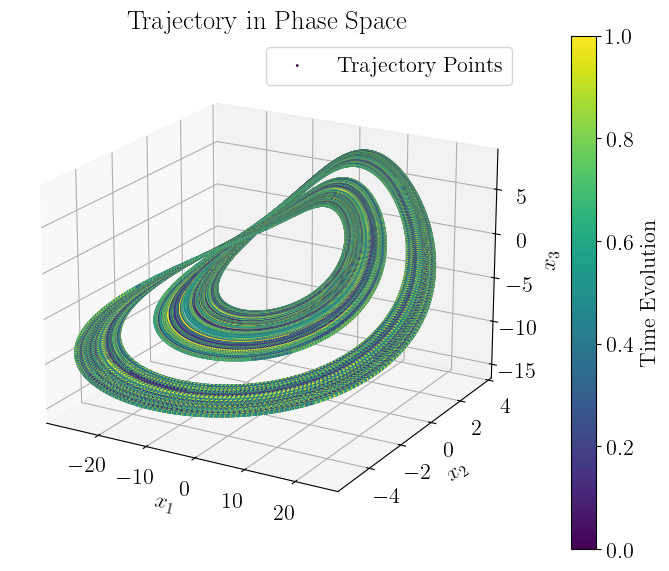

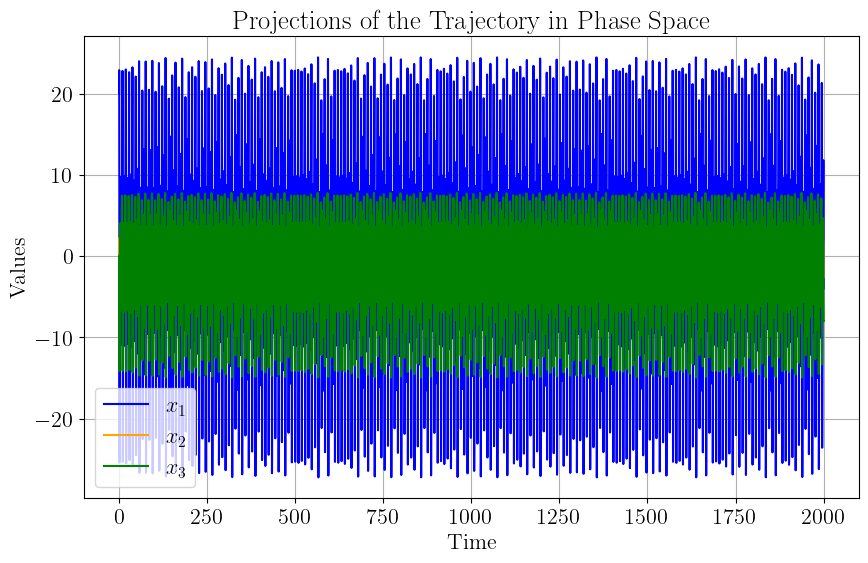

In [90]:
a, b, c = q2.coefficients
y_f = np.roots([a, b-1, c])[0]  # fixed point of the polynomial q2
str = f"q2 is the polynomial ${a:.2f}x^2+{b:.2f}-{np.abs(c):.2f}\n" + \
      f"The fixed point of q2 is $y_f={y_f:.2f}$" 
        # forgot linearly stable


# Example usage
x1_0 = y_f
x2_0 = get_x2_fit(y_f)
return_event.terminal = 3
x1_tr, x2_tr = integrate_and_find_return(x1_0, x2_0, t_span=(0, 1000))

def integrate_flow(x0, t_span):
    sol = solve_ivp(system, t_span, x0, dense_output=True, max_step=0.01)
    t = sol.t  # time points
    x = sol.y  # solution at these time points
    x1, x2, x3 = x
    return t, x1, x2, x3

# Plot the trajectory in the phase space
# Notice that the trajectory is 4D, so we plot (x1, x2, x3) in 3D and 
# give each point a color according to the time evolution.
t, x1_tr, x2_tr, x3_tr = integrate_flow([x1_0, x2_0, 0], t_span=(0, 2000))
points = zip(x1_tr, x2_tr, x3_tr)
color_values = plt.cm.viridis(np.linspace(0, 1, len(t)))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
# decrease the size of the points to avoid cluttering
ax.scatter(x1_tr, x2_tr, x3_tr, c=color_values, s=1, label='Trajectory Points')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Trajectory in Phase Space')

# add a color bar to indicate the time evolution
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
cbar.set_label('Time Evolution')
ax.view_init(elev=20, azim=-60)  # Adjust the view angle
plt.tight_layout()
plt.legend()
plt.show()

# plot projections of the trajectory in the phase space in a single plot
plt.figure(figsize=(10, 6))
plt.plot(t, x1_tr, label='$x_1$', color='blue')
plt.plot(t, x2_tr, label='$x_2$', color='orange')
plt.plot(t, x3_tr, label='$x_3$', color='green')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Projections of the Trajectory in Phase Space')
plt.legend()
plt.grid()
plt.show()





## Determine Quasi-Periodic Trajectory

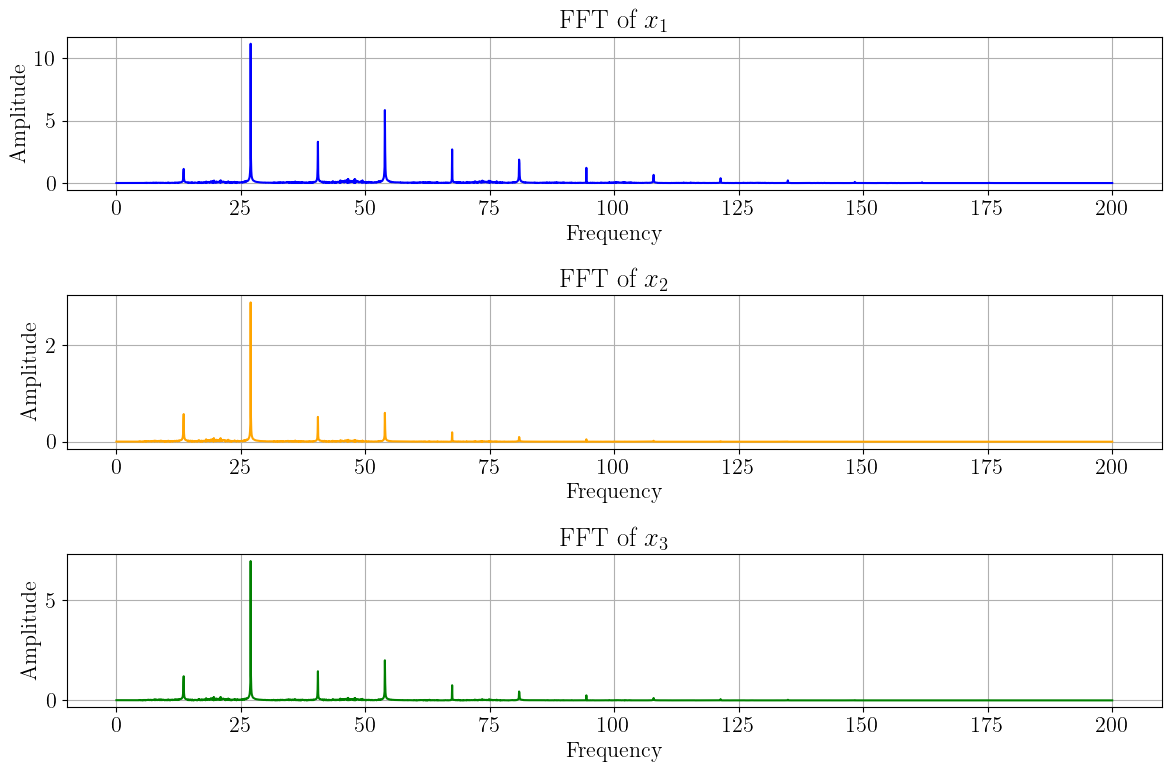

In [92]:
# Compute the FFT of the trajectory in the all directions
from scipy.fft import fft, fftfreq
def compute_fft(x, t):
    N = len(x)
    T = t[1] - t[0]  # Sampling interval
    yf = fft(x)
    xf = fftfreq(N, T)[:N//2]
    # cut xf until 50 Hz
    xf = xf[xf <= 200]
    yf = yf[:N//2]
    # cut yf to match xf
    yf = yf[:len(xf)]
    # Normalize the amplitude
    yf = 2.0/N * np.abs(yf)
    return xf, yf

xf1, yf1 = compute_fft(x1_tr, t)
xf2, yf2 = compute_fft(x2_tr, t)
xf3, yf3 = compute_fft(x3_tr, t)

# Plot the FFT results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(xf1, yf1, color='blue')
plt.title('FFT of $x_1$')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(xf2, yf2, color='orange')
plt.title('FFT of $x_2$')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(xf3, yf3, color='green')
plt.title('FFT of $x_3$')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

## Subsection 1ץ

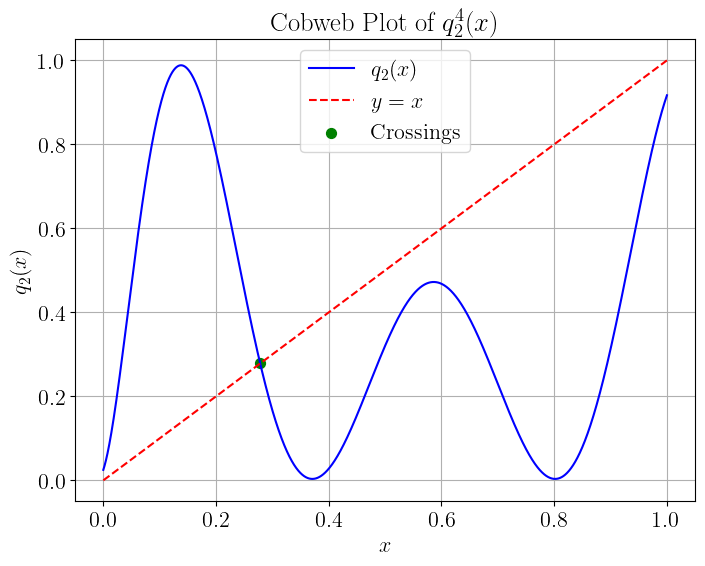

fixed point at 0.278 with orbit [0.278, 0.278, 0.278] and coding 000


In [ ]:
def q2(x):
    return 1 - 3.4 * x + 2.9 * x**2
x_e = 3.4 / 5.8

def q2_n(x, n):
    for _ in range(n):
        x = q2(x)
    return x

def get_coding(orbit):
    coding = []
    for x in orbit:
        if 0 <= x < x_e:
            coding.append('0')
        elif x_e <= x < 1:
            coding.append('1')
    return ''.join(coding)

x = np.linspace(0, 1, 10000)
y = q2_n(x, 3)
# count number of croosings of y = x
crossings = np.where(np.diff(np.sign(y - x)))[0]
plt.figure(figsize=(8, 6))
plt.title('Cobweb Plot of $q_2^4(x)$')
plt.xlabel('$x$')
plt.ylabel('$q_2(x)$')
plt.plot(x, y, label='$q_2(x)$', color='blue')
plt.plot(x, x, label='$y = x$', color='red', linestyle='--')
plt.scatter(x[crossings], y[crossings], color='green', label='Crossings', s=50)
plt.legend()
plt.grid()
plt.show()

for crossing in crossings:
    orbit = []
    for n in range(3):
        orbit.append(q2_n(x[crossing], n))
    if np.abs(orbit[0] - orbit[1]) <= 1e-2:
        print(f"fixed point at {x[crossing]:.3f} with orbit {[round(x, 3) for x in orbit]}" + \
              f" and coding {get_coding(orbit)}")
    elif np.abs(orbit[0] - orbit[2]) <= 1e-2:
        print(f"2-period orbit at {x[crossing]:.3f} with orbit {[round(x, 3) for x in orbit]}" + \
              f" and coding {get_coding(orbit)}")
    else:
        print(f"4-period orbit at {x[crossing]:.3f} with orbit {[round(x, 3) for x in orbit]}" + \
              f" and coding {get_coding(orbit)}")
        
    
